Tutorial Explanation [here](https://adversarial-ml-tutorial.org/linear_models/). We need to solve a minimax problem here (just like game theory)

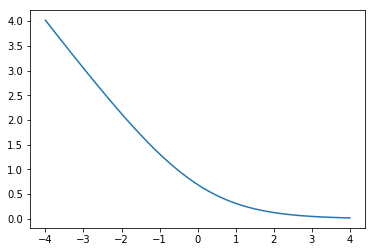

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

x = np.linspace(-4,4)
plt.plot(x, np.log(1+np.exp(-x)))

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [11]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.002448	0.014473	0.000473	0.003330
0.001421	0.005498	0.000473	0.002568
0.001263	0.004461	0.000473	0.002277
0.001026	0.003921	0.000473	0.002243
0.000947	0.003583	0.000473	0.002043
0.000790	0.003193	0.000473	0.002079
0.000947	0.002982	0.000473	0.001957
0.000790	0.002890	0.000473	0.001891
0.000790	0.002722	0.000946	0.001849
0.000711	0.002534	0.000473	0.001878


Text(0.5, 1.0, 'True Label: 0')

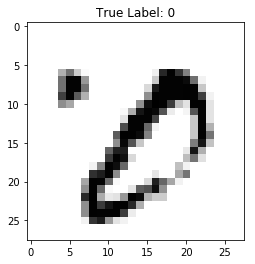

In [13]:
X_test = (test_loader.dataset.data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.targets
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

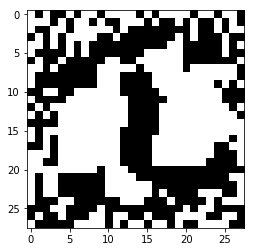

In [14]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [15]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
  
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8340425531914893, 3.2464862095266933)


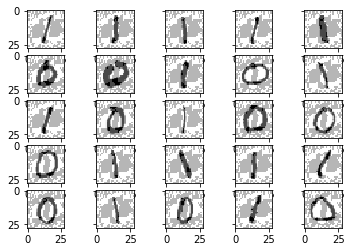

In [16]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

Now creating a adversarially robust linear model!

In [17]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
  
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.149309	0.377042	0.063830	0.214034
0.072483	0.223311	0.044917	0.162429
0.063008	0.197553	0.044444	0.157442
0.057639	0.183680	0.041608	0.148550
0.053139	0.174679	0.039243	0.137593
0.049664	0.167662	0.035934	0.132619
0.047612	0.162520	0.033097	0.122757
0.046585	0.158418	0.032151	0.122096
0.044848	0.154468	0.033097	0.127738
0.043269	0.151494	0.032624	0.124384
0.041690	0.149169	0.028842	0.114882
0.040111	0.146759	0.027896	0.116990
0.038926	0.144970	0.027896	0.111648
0.038295	0.143158	0.026478	0.104280
0.037742	0.141746	0.026478	0.106106
0.036715	0.140391	0.026478	0.106851
0.036321	0.138888	0.026478	0.107302
0.035531	0.137927	0.025059	0.102032
0.035057	0.137283	0.025059	0.102352
0.033794	0.136318	0.024586	0.099917


In [18]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006080	0.015215	0.003310	0.008166


We’re getting 0.3% error on the test set. This is good, but not as good as we were doing with standard training; we’re now making 8 mistakes on the test set, instead of the 1 that we were making before. And this is not just a random effect of this particular problem, or the fact that it is relatively easy. Rather, perhaps somewhat surprisingly, there is a fundamental tradeoff between clean accuracy and robust accuracy, and doing better on the robust error leads to higher clean error. 

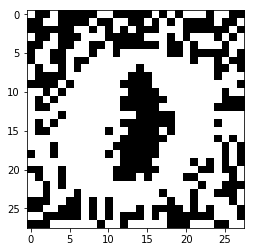

In [19]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

That looks substantially more like a zero than what we saw before. Thus, we have some (admittedly, at this point, fairly weak) evidence that robsut training may also lead to “adversarial directions” that are inherrently more meaningful. Rather than fooling the classifier by just adding “random noise” we actually need to start moving the image in the direction of an actual new image (and even doing so, at least with this size epsilon, we aren’t very successful at fooling the classifier).

Now, this means linear models can be made rubust. But what about deep networks? It turns out that the solution found in that case is not optimal because of the non-convexity of the function. Thus there's no direct, optimal way to attack the adversary. Of course, as the adversary would say, 

![alt text](https://media1.tenor.com/images/b1ba542ebb4359ffd462ab51dced8aa7/tenor.gif?itemid=9579329)